##  Example: The Lotka–Volterra equations 

For more information, please see

1: Wikipedia: https://en.wikipedia.org/wiki/Lotka%E2%80%93Volterra_equations

2: Wolfram: https://mathworld.wolfram.com/Lotka-VolterraEquations.html

In [1]:
# Note: Please initiate Jupyter Lab where this script is located
# Note: re-start the python kernel if some attribute of a class is not identified
# Note: there is an abuse of notation of x (X) and v. The x (X) in the code mostly means the v in the paper
# Note: the hyperparameters have been adjusted for faster execution within JupyterLab. 
#        For more precise results and improved efficiency, we recommend running the code locally with appropriately fine-tuned hyperparameters

import torch
import os
import math
import numpy as np
import sys
import time
import copy
from matplotlib import pyplot as plt
from PIL import Image
from pdf2image import convert_from_path
from Tools.Data_generation import * # Data generation
from Tools.DNN_tools import *       # Common tools in DNN modeling
from Tools.Training_tools import *  # Main trainer class of the inVAErt network and the training/testing algorithm
from Tools.plotter import *         # Common plotting tools 

matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
plt.rcParams.update({'figure.max_open_warning': 0})

### Introduction

The Lotka–Volterra equations are widely used to model the predator-prey ecological relationships. The system is described by the following coupled ODEs:

$$
\begin{align*}
\dot{y}_1 &=  \alpha y_1 - \beta y_1 y_2 \ ,\\
\dot{y}_2 &=  \delta y_1 y_2 - \gamma y_2 \ .
\end{align*}
$$

* $y_1$: Prey population (density)
* $y_2$: Predator population (density)
* $\alpha$: Natural growth rate of prey
* $\beta$:  Predation rate
* $\delta$: Predator growth rate due to predation
* $\gamma$: Natural death rate of predator

We will also study a parametric family of this system, the interested parameter ranges are listed in the following table:

| | |
|-----|:-----|
|$\alpha$| [0.1, 0.5]|
|$\beta$|  [0.5, 1]|
|$\delta$|  [0.5, 1.5]|
|$\gamma$|  [0.5, 1.5]|

For using the inVAErt networks, we study how **maximum** populations of the prey and predator can be affected by all the rate parameters. In this regard, we consider the map $\boldsymbol{y} = \mathcal{F}(\boldsymbol{v})$, where

$$
\boldsymbol{v} = [\alpha, \beta, \delta, \gamma]^T \in \boldsymbol{\mathcal{V}} \in \mathbb{R}^4, \ \boldsymbol{y} = [\text{max}(y_1) , \text{max}(y_2) ]^T \in \boldsymbol{\mathcal{Y}} \in \mathbb{R}^2 \ .
$$

The latent variable $\boldsymbol{w}$ will have the inherent dimensionality of: $\dim(\boldsymbol{w}) = \dim(\boldsymbol{v}) - \dim(\boldsymbol{y}) = 2$. In addition, we set the initial condition as $\boldsymbol{y}_0 = [1,1]^T$ and extract the maximum values from the last a few cycles. For more details, please refer to the script: ```Data_generation.py```.

**Note:** The stability of the Lotka–Volterra system depends on the choice of inputs, i.e. $\alpha, \beta, \delta, \gamma$, as well as the initial condition $\boldsymbol{y}_0$, hence one should be careful when tuning these parameters. The quality of training data also relies on the type of numerical integrator. Thus, for more stable and accurate results, we will utilize an implicit RK4 solver.

### Basic setup: device, precision and folder creation 

For each case, remember to change the case label

In [2]:
# Basic setup
#--------------------------------------------------------------------------------------#
# determine if to use GPU, GPU is faster with large mini-batch
device = 'cpu' #torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

# set tensor type to double
torch.set_default_dtype(torch.float64)

# path for saving the synthetic dataset
os.makedirs('Dataset/', exist_ok = True)   

# path for saving the trained neural network model 
os.makedirs('Model_save/', exist_ok = True)

# case label
prefix = 'Lotka-Volterra'
#--------------------------------------------------------------------------------------#

### Data generation, scaling and training/testing dataset split

To generate training data, we take uniform random samples of $\alpha, \beta, \delta, \gamma$ from the ranges listed in the above table and solve the ODE $1\times 10^4$ times.

In [3]:
# Data generation
# X: input tensor of the inVAErt network, size: number of samples x number of feature
#    number of feature = dim(V) or dim(V) + dim(D_v), i.e. if auxiliary data is used, see Section 2.1
# Y: output tensor of the inVAErt network, size: number of samples x number of feature
#    number of feature = dim(Y)
#-------------------------------------------------------------------------#
# If True, save the generated data, If False, load the generated data. 
Saving      = False 

# Note: Change ''Saving == True'' only when you need to change sample size or parameter ranges, otherwise keep it equal to False. Data generation for this case is costly in Jupyter lab, for 
#       generating 1x10^4 training samples, the waiting time is > 10 minutes. You may also run this script locally.

# If True, scale the data, use the z-std method (c.f. Appendix of the paper)
Scaling     = True

# Define data size and ranges
Sample_size = int(1e4)       # how many samples needed
alpha       = [0.1, 0.5]      
beta        = [0.5, 1.]
delta       = [0.5, 1.5]
gamma       = [0.5, 1.5]

# Generate or load the data
if Saving == True:
	# call data generator function and save the data
	X,Y =  Data_PredPrey(Sample_size, alpha, beta, delta, gamma, Saving) 
    # load the generated data from file
else:
	X   = np.loadtxt('Dataset/' + prefix + '_X.csv', delimiter = ',', ndmin=2) 
	Y   = np.loadtxt('Dataset/' + prefix + '_Y.csv', delimiter = ',', ndmin=2) #ndmin = 2 means: always keep array dimension = 2

# backup for later plotting
Y_plot = copy.deepcopy(Y)
V_plot = copy.deepcopy(X)

# Data-normalization if needed
if Scaling == True:
    # call z-standardization 
	scaler = Zscaling()
	X, muX, stdX = scaler.z_std(X) # apply transformation, record the mu and std
	Y, muY, stdY = scaler.z_std(Y) # apply transformation, record the mu and std
    
# convert to pytorch tensors from numpy array
X = torch.from_numpy(X).to(device)
Y = torch.from_numpy(Y).to(device)

# Training-Testing-Dataset-Split
T_portion = 0.75 # 75% for training, the rest for testing
train_tensor, train_truth_tensor, test_tensor, test_truth_tensor = \
									TT_split(Sample_size, T_portion, X, Y)

print('data-generation is done...')
#-------------------------------------------------------------------------#

data-generation is done...


### Define hyperparameters, initiate trainer class, and define each component of the inVAErt network

For the current setup, we define the emulator $\mathscr{N}_e \ $, the Real-NVP based normalizing flow model $\mathscr{N}_f$ and the variational decoder (VAE + decoder) $\mathscr{N}_v$ + $\mathscr{N}_d$ as three separate modules and train them independently. This allows us to always use the exact label instead of network predictions. However, for the stochastic extension of our inVAErt network, we need to trained them altogether. For more details, please see the appendix and Section 2.4 of the paper.

Note: to make the latent space more expressive, we increase its dimensionality by 6, i.e. ```latent_plus = 6```, which together with the inherent dimensionality, makes $\boldsymbol{w} \in \mathbb{R}^{8}$.

In [4]:
# Define hyperparameters, initiate trainer and define models 
#-------------------------------------------------------------------------------#
# init folder
folder_name = 'Model_save/'+ prefix 
os.makedirs(folder_name, exist_ok = True) # warning: be careful the overwrite here

# if scaled, save the scaling constants
if Scaling == True:
    scaler.save_scaling_constants(folder_name, muX, muY, stdX, stdY)

# Define hyperparameters, see, e.g. appendix of the paper
# Note: grid search for more optimal parameters TBD
para_dim    =   X.shape[1]              # dim(V). In this case, we do not have auxillary data
nB          =   [128,128,128]           # mini-batch size of N_e, N_f, N_v+N_d
learning_rate = [1e-3, 1e-3, 1e-3]      # initial learning rate for N_e, N_f, N_v+N_d
encoder_para  = [16,8,'silu']           # num_of_neuron, num_of_layer, type_of_act fun for emulator N_e
nf_para       = [8,4,4, False]          # num_of_neuron, num_of_layer_of_each_block, num_of_affine_coupling_blocks, \
                                        # if_using_batch_norm for Real-NVP normalizing flow model N_f
vae_para      = [24,6,'silu']           # num_of_neuron, num_of_layer, type_of_act fun for VAE N_v
decoder_para  = [32,6,'silu']           # num_of_neuron, num_of_layer, type_of_act fun for decoder N_d
penalty       = [1, 200, 10]            # penalty for KL div and decoder reconstruction loss, and the encoder re-constraint loss 
lr_min        = [1e-5, 1e-5, 1e-5]      # minimal learning rate of N_e, N_f, N_v+N_d
decay         = [0.997, 0.993, 0.9975]   # learning rate decay rate of N_e, N_f, N_v+N_d
weight_decay  = [0,1e-3,0.]           # L2 regularization of N_e, N_f, N_v+N_d    
latent_plus    = 6                      # how many additional dimensionality needed
#--------------------------------------------------------------------------------#

# Initiate trainer class
Trainer = Training(X, Y, para_dim, train_tensor = train_tensor, train_truth_tensor = train_truth_tensor,\
									 test_tensor = test_tensor, test_truth_tensor = test_truth_tensor, latent_plus = latent_plus)

# Define models, i.e. N_e, N_f, N_v+N_d
Encoder_model, NF_model, Decoder_model = Trainer.Define_Models(device, encoder_para, nf_para, vae_para, decoder_para)

Number of trainable para for encoder is:1746
Number of trainable para for NF sampler is:1352
Number of trainable para for VAE+decoder is:7628


### Training step of the emulator $\mathscr{N}_e$

Waiting time: < 2 min

In this case, the forward model is simple to learn, so we skip showing the evaluation results. A trained emulator $\mathscr{N}_e$ will be used to build the forward re-constraint loss $\mathcal{L}_r$ when we train the variational encoder and the decoder, i.e. $\mathscr{N}_d + \mathscr{N}_v$, in the following part.

In [5]:
#--------------------------------------------start to train each component of inVAErt--------------------------------------------------#
%matplotlib agg
# Training and testing step of the encoder, i.e. the emulator N_e
Trainer.Encoder_train_test(folder_name, Encoder_model, lr_min[0], learning_rate[0], decay[0], nB[0])
%matplotlib inline



---------------Start to train the encoder-----------------
Total number of epoches for training encoder is:1532
Encoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, forward loss: 9.830e-01 , forward acc : -0.398106% , current lr: 1.000e-03
Testing: forward loss: 1.056e+00 , forward acc : 0.672252%
Training: Epoch: 200, forward loss: 1.957e-04 , forward acc : 99.979567% , current lr: 5.483e-04
Testing: forward loss: 1.724e-04 , forward acc : 99.983562%
Training: Epoch: 400, forward loss: 1.260e-04 , forward acc : 99.986989% , current lr: 3.007e-04
Testing: forward loss: 9.046e-05 , forward acc : 99.991239%
Training: Epoch: 600, forward loss: 9.102e-05 , forward acc : 99.991011% , current lr: 1.649e-04
Testing: forward loss: 5.335e-05 , forward acc : 99.994793%
Training: Epoch: 800, forward loss: 7.687e-05 , forward acc : 99.992648% , current lr: 9.039e-05
Testing: forward loss: 4.701e-05 , forward acc : 99.995416%
Training: Epoch: 1000, forward loss: 7.059

In [6]:
# plotting specs
fs = 24
plt.rc('font',  family='serif')
plt.rc('xtick', labelsize='x-small')
plt.rc('ytick', labelsize='x-small')
plt.rc('text',  usetex=True)

### Training and testing step of the Real-NVP based normalizing flow model $\mathscr{N}_f$

Waiting time: < 2 min

In [7]:
# # training and testing step of the Real-NVP based NF model
%matplotlib agg
Trainer.NF_train_test(folder_name, NF_model, lr_min[1], learning_rate[1], decay[1], nB[1])
# %matplotlib inline



---------------Start to train the Real NVP-----------------
Total number of epoches for training NF is:655
NF: Total num of training batches:59, testing batches:20
Training: Epoch: 0, likelihood loss: 2.663e+00 , current lr: 1.000e-03
Testing: likelihood loss: 2.532e+00
Training: Epoch: 200, likelihood loss: 1.412e+00 , current lr: 2.454e-04
Testing: likelihood loss: 1.448e+00
Training: Epoch: 400, likelihood loss: 1.387e+00 , current lr: 6.021e-05
Testing: likelihood loss: 1.409e+00
Training: Epoch: 600, likelihood loss: 1.379e+00 , current lr: 1.478e-05
Testing: likelihood loss: 1.407e+00


### Verification of the Real-NVP based NF model $\mathscr{N}_f$ 

We pick random samples of $\boldsymbol{z}$ from the base distribution of the NF model, i.e. standard normal distribution, and apply the trained NF transformations:  $\boldsymbol{z} \to \boldsymbol{y}$ (Recall $\boldsymbol{y} = [\text{max}(y_1) , \text{max}(y_2)]^T$ ). The learned distributions of $\text{max}(y_1) , \text{max}(y_2)$ as well as their correlation match well with the true data (Exact), except for the tails of the distribution due to the scarcity of data.

Text(0.5, 1.0, '$y_{1,max}$-$y_{2,max}$ correlation')

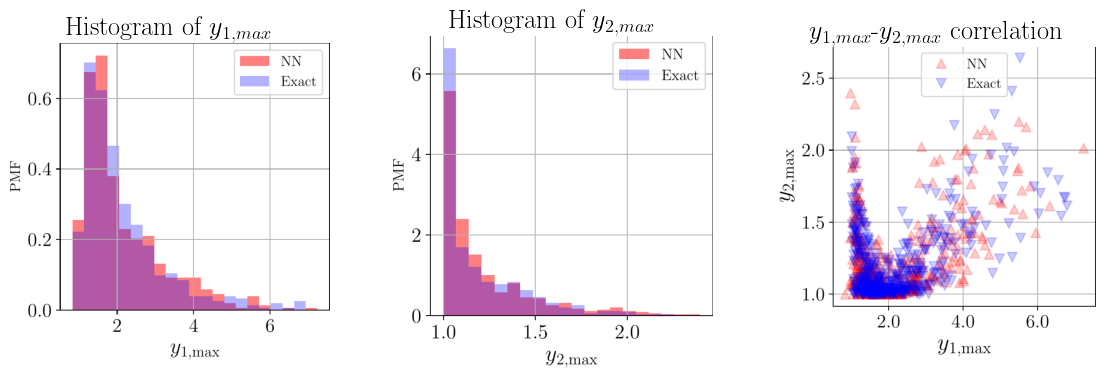

In [8]:
NF_Sample_size = 500 # How many samples needed

# sample z from N(0,1) and transform back to y
Y_hat_samples = NF_model.sampling(NF_Sample_size, NF_model, seed_control= 0) # pick a random seed here

# Scaling back if needed
if Scaling == True:
    Y_hat_samples = scaler.scale_it_back(Y_hat_samples, muY, stdY)

# where to save the figures
path     = folder_name + '/figures/NF'

#Save histogram and scatter correlation plots
%matplotlib agg
hist_plot(path, 'y1max-hist', Y_hat_samples[:,0], r'$y_{1,\max}$', exact=Y_plot[:NF_Sample_size,0]) # hist of Pmax
hist_plot(path, 'y2max-hist', Y_hat_samples[:,1], r'$y_{2,\max}$', exact=Y_plot[:NF_Sample_size,1]) # hist of Pmin
scatter2D_plot(path, 'y1max-y2max-corr', Y_hat_samples, r'$y_{1,\max}$', r'$y_{2,\max}$', exact=Y_plot[:NF_Sample_size,:])
%matplotlib inline

# show figures
plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
im1 = convert_from_path(path + '/y1max-hist.pdf')
plt.imshow(im1[0])
plt.axis('off')
plt.title('Histogram of $y_{1,max}$', fontsize = fs-5)

plt.subplot(1, 3, 2)
im2 = convert_from_path(path + '/y2max-hist.pdf')
plt.imshow(im2[0])
plt.axis('off')
plt.title('Histogram of $y_{2,max}$', fontsize = fs-5)

plt.subplot(1, 3, 3)
im3 = convert_from_path(path + '/y1max-y2max-corr.pdf')
plt.imshow(im3[0])
plt.axis('off')
plt.title('$y_{1,max}$-$y_{2,max}$ correlation', fontsize = fs-5)

### Training and testing step of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$

Waiting time: < 7 min

In [9]:
# training and testing step of the VAE and decoder
%matplotlib agg
Trainer.Decoder_train_test(folder_name, Decoder_model, lr_min[2], learning_rate[2], decay[2], nB[2], penalty,\
                                               l2_decay = weight_decay[2], EN = Encoder_model, residual = False)
%matplotlib inline



---------------Start to train the variational decoder-----------------
Total number of epoches for training variational decoder is:1839
VAEDecoder: Total num of training batches:59, testing batches:20
Training: Epoch: 0, inversion loss: 9.520e-01 , inversion acc : 4.719630% , KL : 1.029e-01 , Encoder_reconstraint: 1.241e+00 , current lr: 1.000e-03
Testing: inversion loss: 7.681e-01 , inversion acc : 23.517213% , KL : 6.551e-01 , Encoder_reconstraint: 5.444e-01
Training: Epoch: 200, inversion loss: 7.553e-03 , inversion acc : 99.244275% , KL : 5.341e+00 , Encoder_reconstraint: 1.376e-03 , current lr: 6.062e-04
Testing: inversion loss: 1.967e-03 , inversion acc : 99.803969% , KL : 5.281e+00 , Encoder_reconstraint: 1.384e-03
Training: Epoch: 400, inversion loss: 6.388e-03 , inversion acc : 99.358927% , KL : 4.966e+00 , Encoder_reconstraint: 5.805e-04 , current lr: 3.674e-04
Testing: inversion loss: 6.821e-04 , inversion acc : 99.932113% , KL : 5.010e+00 , Encoder_reconstraint: 5.175e-04

### Verification of the variational auto-encoder and decoder $\mathscr{N}_v + \mathscr{N}_d$   

#### Task: non-identifiability analysis

In this task, we fix a $\boldsymbol{y}^*$ sampled from the previously trained NF model ($\mathscr{N}_f$) and sample $N$ latent variables of $\boldsymbol{w}$ from the latent space, which is the standard Gaussian distribution. This will give us $N$ values of $\tilde{\boldsymbol{y}}^* = [\boldsymbol{y}^*, \boldsymbol{w}]^T$ that correpond to the same $\boldsymbol{y}^*$ and different values of $\boldsymbol{w} \sim \mathcal{N}(\boldsymbol{0},\mathbf{I})$. 

Then, we apply the trained decoder $\mathscr{N}_d \ $ for model inversion, which predicts the system inputs $\widehat{\boldsymbol{v}}$ that lives in the non-identifiable subspace (manifold) of $\boldsymbol{\mathcal{V}}$ given $\boldsymbol{y}^*$.

Note: we apply the PC (Predictor-Corrector) sampling method here to improve the sampling from the latent space. We set the iteration number $R = 4$, i.e. ```denoise=4```.

In [10]:
# sample one y^* from the trained NF 
y_fix  = NF_model.sampling(1, NF_model, seed_control= 1) # Try another point, change seed, and comment out the following block

# # --------------- interested observation ------------------------ #
# # Note: try a random NF sample, comment out this block
# if Scaling == True: # forward scaling if needed
#     y_fix   = (np.array([[1.86521321, 1.03473041]]) - muY )/stdY
# else:
#     y_fix   = np.array([[1.86521321, 1.03473041]])
# # ---------------------------------------------------------------- #

# How many latent variables w will be drawn from the latent space
W_size = 500

# Decoding with trained N_d
X_samples = Decoder_model.inversion_sampling(Decoder_model, W_size, seed_control = 0 , Task = 'FixY', y_given = y_fix, denoise=4)

# Scaling back if needed
if Scaling == True:
	X_samples   = scaler.scale_it_back(X_samples,muX,stdX) # scale back the inverse predictions of v
	y_fix       = scaler.scale_it_back(y_fix, muY, stdY) # scale back the fixed y, i.e. y_1max y_2_max

print('Fixed value is:' + str(y_fix))

Fixed value is:[[2.55893672 1.09705233]]


Recall $\boldsymbol{v} \in \mathbb{R}^4$, so it is challenging to plot all 4 components altogether. Instead, we plot the binary correlations in the following pictures.

(-0.5, 755.5, 735.5, -0.5)

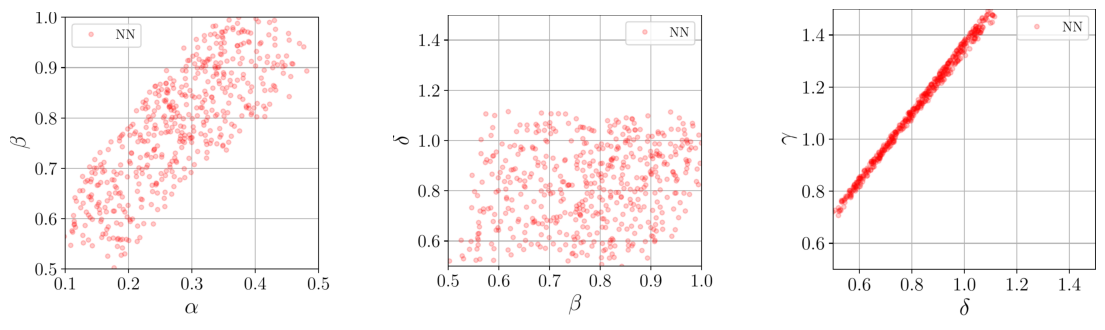

In [11]:
path_inv     = folder_name + '/figures/Inversion'

#Save scatter correlation plot
%matplotlib agg
scatter2D_plot(path_inv , 'alpha-beta-corr', X_samples[:,[0,1]], \
			r'$\alpha$',r'$\beta$', Mkr = 'r.', fmt=['%.1f','%.1f'], ranges=[0.1,0.5, 0.5, 1])
scatter2D_plot(path_inv , 'alpha-delta-corr', X_samples[:,[0,2]], \
			r'$\alpha$',r'$\delta$', Mkr = 'r.', fmt=['%.1f','%.1f'], ranges=[0.1,0.5, 0.5, 1.5])
scatter2D_plot(path_inv , 'alpha-gamma-corr', X_samples[:,[0,3]], \
			r'$\alpha$',r'$\gamma$', Mkr = 'r.', fmt=['%.1f','%.1f'], ranges=[0.1,0.5, 0.5, 1.5])
scatter2D_plot(path_inv , 'beta-delta-corr', X_samples[:,[1,2]], \
			r'$\beta$',r'$\delta$', Mkr = 'r.', fmt=['%.1f','%.1f'], ranges=[0.5,1, 0.5, 1.5])
scatter2D_plot(path_inv , 'beta-gamma-corr', X_samples[:,[1,3]], \
			r'$\beta$',r'$\gamma$', Mkr = 'r.', fmt=['%.1f','%.1f'], ranges=[0.5,1, 0.5, 1.5])
scatter2D_plot(path_inv , 'delta-gamma-corr', X_samples[:,[2,3]], \
			r'$\delta$',r'$\gamma$', Mkr = 'r.', fmt=['%.1f','%.1f'], ranges=[0.5,1.5, 0.5, 1.5])
%matplotlib inline

# show correlation figures
plt.figure(figsize=(14, 6.5))
plt.subplot(1, 3, 1)
im_v1 = convert_from_path(path_inv + '/alpha-beta-corr.pdf') # correlation of alpha and beta
plt.imshow(im_v1[0])
plt.axis('off')

plt.subplot(1, 3, 2)
im_v2 = convert_from_path(path_inv + '/beta-delta-corr.pdf') # correlation of beta-delta
plt.imshow(im_v2[0])
plt.axis('off')

plt.subplot(1, 3, 3)
im_v3 = convert_from_path(path_inv + '/delta-gamma-corr.pdf') # correlation of delta-gamma
plt.imshow(im_v3[0])
plt.axis('off')

Finally, we check if the given Lotka-Volterra system is indeed non-identifiable on these inverse predictions. To do so, we forward 100 inverse predictions $\widehat{\boldsymbol{v}}$ through the RK4 solver and compare the obtained $y_{1,\max}$ and $y_{2,\max}$ with the previously fixed value $\boldsymbol{y}^*$. The results are shown below, as we see most predicted values are close to the fixed $\boldsymbol{y}^*$.

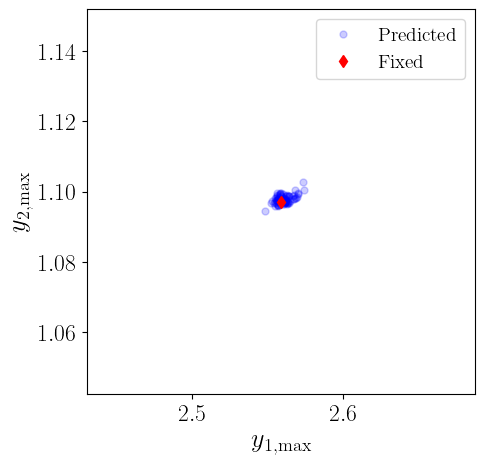

In [12]:
y_check = []
for i in range(len(X_samples[:100])):
    _, y_interested = Data_PredPrey(1, [X_samples[i,0], X_samples[i,0]], [X_samples[i,1], X_samples[i,1]],\
                                    [X_samples[i,2], X_samples[i,2]], [X_samples[i,3], X_samples[i,3]], False)
    y_check.append(y_interested[0])
y_check = np.array(y_check)
plt.figure(figsize=(5,5))
plt.plot(y_check[:,0], y_check[:,1], 'bo', markersize = 5, alpha = 0.2, label = 'Predicted')
plt.plot(y_fix[0,0], y_fix[0,1], 'rd', label = 'Fixed')
plt.xlabel('$y_{1,\max}$',fontsize=fs-5)
plt.ylabel('$y_{2,\max}$',fontsize=fs-5)
plt.xlim([ y_fix[0,0] * (1-0.05), y_fix[0,0] * (1+0.05)  ])
plt.ylim([ y_fix[0,1] * (1-0.05), y_fix[0,1] * (1+0.05)  ])
plt.tick_params(labelsize=fs-7)
plt.legend(fontsize=fs-10)
plt.savefig(path_inv + '/invert-verify.pdf')